In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [48]:
import os
import sys

# 確保項目根目錄在模組路徑中
project_root = os.path.abspath("COVID-19-TIME-SERIES-PREDICT")  # 替換為你的根目錄路徑
if project_root not in sys.path:
    sys.path.append(project_root)

# 導入模組
from utils.common_tools import *

In [49]:
data = read_covid_data()
data.head()

['AFG' 'OWID_AFR' 'ALB' 'DZA' 'AND' 'AGO' 'AIA' 'ATG' 'ARG' 'ARM' 'ABW'
 'OWID_ASI' 'AUS' 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ'
 'BEN' 'BMU' 'BTN' 'BOL' 'BES' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA'
 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF' 'TCD' 'CHL' 'CHN' 'COL' 'COM'
 'COG' 'COK' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI'
 'DMA' 'DOM' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'OWID_EUR'
 'OWID_EUN' 'FRO' 'FLK' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO' 'DEU'
 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GTM' 'GGY' 'GIN' 'GNB' 'GUY' 'HTI'
 'OWID_HIC' 'HND' 'HKG' 'HUN' 'ISL' 'IND' 'IDN' 'OWID_INT' 'IRN' 'IRQ'
 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN' 'JEY' 'JOR' 'KAZ' 'KEN' 'KIR'
 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU'
 'OWID_LIC' 'OWID_LMC' 'LUX' 'MAC' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT'
 'MHL' 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MCO' 'MNG' 'MNE' 'MSR' 'MAR' 'MOZ'
 'MMR' 'NAM' 'NRU' 'NPL' 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'NIU'
 'OWI

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [50]:
data = extract_target_data(data)
data.head()

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

,date,new_cases
0,2020-02-24,5.0
1,2020-02-25,0.0
2,2020-02-26,0.0
3,2020-02-27,0.0
4,2020-02-28,0.0


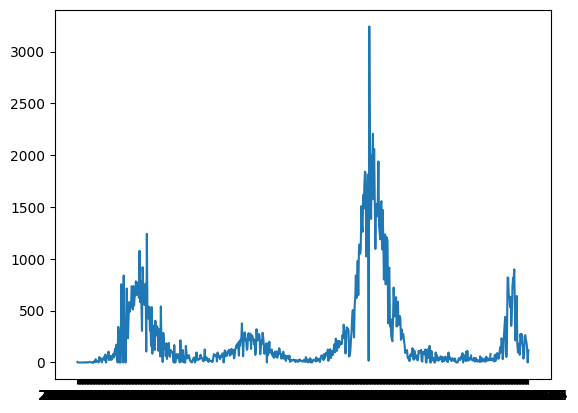

In [51]:
# Plot data
plt.plot(data["date"], data["new_cases"])

In [21]:
data.head()

,date,new_cases
0,2020-02-24,5.0
1,2020-02-25,0.0
2,2020-02-26,0.0
3,2020-02-27,0.0
4,2020-02-28,0.0


ADF Statistic: -3.252431044096394
p-value: 0.01714340731693615
Critical Values:
   1%: -3.439314999916068
   5%: -2.8654965012008677
   10%: -2.5688768817372867
數據是穩態的


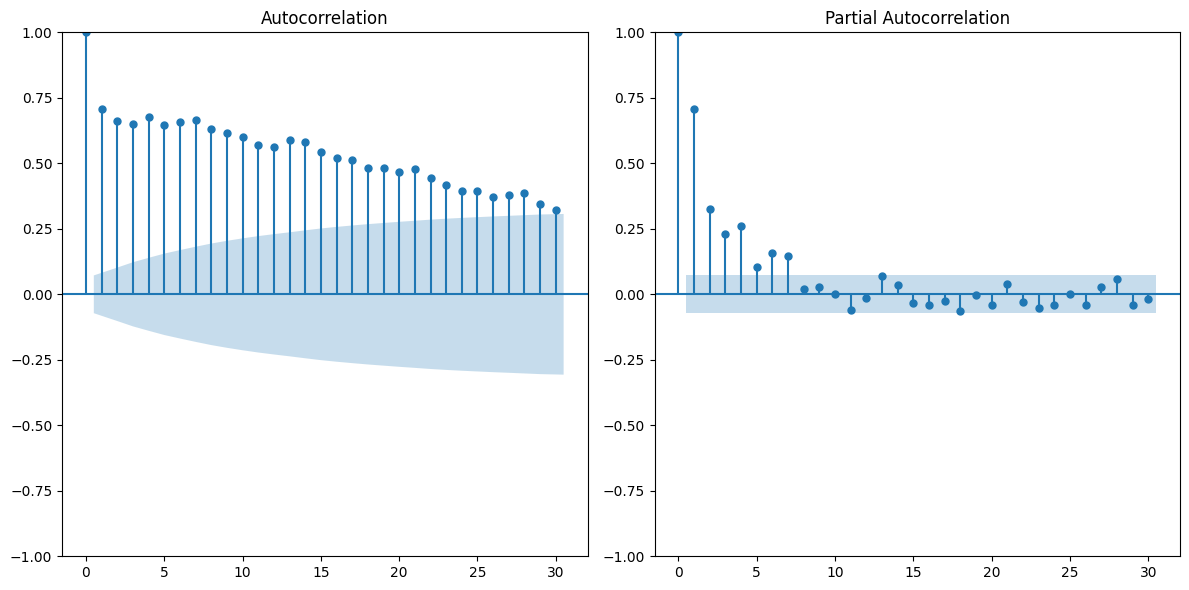

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. 數據清理
data.dropna(inplace=True)

# 2. ADF 單根檢定檢查穩態性
result = adfuller(data["new_cases"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

if result[1] < 0.05:
    print("數據是穩態的")
else:
    print("數據是非穩態的，需要進行差分")

# 3. 繪製 ACF 和 PACF 檢查自相關性
plt.figure(figsize=(12, 6))
plot_acf(data["new_cases"], lags=30, ax=plt.subplot(121))
plot_pacf(data["new_cases"], lags=30, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

* 時序圖：數據具有明顯的波動性和某些高峰，顯示某些非線性結構，但整體趨勢並不顯著，波動在某些時期內似乎穩定。
* ADF 檢定結果：ADF 統計量為 -3.64，p 值為 0.005，表示數據通過了穩態性檢驗，確定數據是穩態的。
* 自相關（ACF）和偏自相關（PACF）：ACF 圖明顯的滯後相關性表明數據具有長期的自相關結構，可能需要用 AR 或 MA 模型進行擬合。PACF 圖在 1 至 2 個滯後項顯著，表示自回歸模型的階數可能是 1 或 2。



In [77]:
best_model = None
best_aic = float("inf")
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                model = ARIMA(data["new_cases"], order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_model = model_fit
                    best_aic = model_fit.aic
            except:
                continue
print("Best Model:", best_model.summary())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\sit

Best Model:                                SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  739
Model:                 ARIMA(2, 2, 2)   Log Likelihood                   0.000
Date:                Sun, 08 Dec 2024   AIC                             10.000
Time:                        00:37:48   BIC                             33.013
Sample:                             0   HQIC                            18.875
                                - 739                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.305e-06   2.65e-05      0.125      0.901   -4.87e-05    5.53e-05
ar.L2          1.0000   1.69e-05   5.93e+04      0.000       1.000       1.000
ma.L1         -2.0000         -0        

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [78]:
# import log
from numpy import log
# 使用初步參數選擇，這裡假設 (p, d, q) = (1, 0, 1)
p, d, q = 2,2,2  # 可以根據 ACF 和 PACF 調整


data["new_cases"] = log(data["new_cases"] + 1)

# 構建 ARIMA 模型
model = ARIMA(data["new_cases"], order=(p, d, q))
model_fit = model.fit()

# 輸出模型摘要
print(model_fit.summary())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\sit

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  739
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -315.568
Date:                Sun, 08 Dec 2024   AIC                            641.136
Time:                        00:37:58   BIC                            664.149
Sample:                             0   HQIC                           650.010
                                - 739                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1097      0.031      3.530      0.000       0.049       0.171
ar.L2         -0.0476      0.027     -1.760      0.078      -0.101       0.005
ma.L1         -1.8477      0.021    -87.486      0.0

In [71]:
# 了解 new_cases 的分布狀態
data.describe()

,new_cases
count,739.000000
mean,4.270620
std,1.801321
min,0.000000
25%,3.367296
50%,4.369448
75%,5.463832
max,8.084562


In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# 劃分數據集
train_size = int(len(data) * 0.8 // 1)  # 使用前 80% 的數據作為訓練集
train = data.iloc[:train_size]     # 訓練集
test = data.iloc[train_size:]      # 測試集

print(f"Train Size: {len(train)}, Test Size: {len(test)}")

# 初始化滾動預測
history = [x for x in train["new_cases"]]  # 使用訓練集的初始數據
predictions = []  # 儲存每次的預測結果

# 滾動預測
for t in range(len(test)):
    # 構建並擬合 ARIMA 模型
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()

    # 預測下一個時間點
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    # 將真實值加入訓練集
    history.append(test["new_cases"].iloc[t])

# 計算各種指標
mse = mean_squared_error(test["new_cases"], predictions)
mae = mean_absolute_error(test["new_cases"], predictions)
r2 = r2_score(test["new_cases"], predictions)
rmse = np.sqrt(mean_squared_error(test["new_cases"], predictions))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")
print(f"Rolling Forecast RMSE: {rmse}")

Train Size: 591, Test Size: 148


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean Squared Error: 0.10426043505842296
Mean Absolute Error: 0.19852451225485698
R2 Score: 0.26169555051073856
Rolling Forecast RMSE: 0.32289384487540634


In [73]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest

# 檢查殘差的自相關性
residuals = model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

# 檢查殘差的正態分佈
stat, p = normaltest(residuals)
print(f"Normality Test: Statistic={stat}, p={p}")
if p > 0.05:
    print("殘差接近正態分佈")
else:
    print("殘差偏離正態分佈")

     lb_stat  lb_pvalue
10  9.719074   0.465476
Normality Test: Statistic=225.83924326626453, p=9.112371689934447e-50
殘差偏離正態分佈


In [74]:
forecast_steps = 10  # 預測 10 步
forecast = model_fit.forecast(steps=forecast_steps)

# 比較真實值與預測值
real_values = test["new_cases"].iloc[:forecast_steps]
rmse = np.sqrt(mean_squared_error(real_values, forecast))
print(f"Multi-step Forecast RMSE: {rmse}")

Multi-step Forecast RMSE: 0.9050291878462682
